# 鐵達尼生存預測（精簡版）
https://www.kaggle.com/c/titanic

In [110]:
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor

## 讀取csv

In [111]:
df_train = pd.read_csv('./data/' + 'titanic_train.csv')
df_test = pd.read_csv('./data/' + 'titanic_test.csv')

## 快速查看資料
- PassengerId: 乘客編號
- Survived: 乘客是否存活（1代表存活，0代表死亡）
- Pclass: 艙位是頭等艙、二等艙還是三等艙
- Name: 乘客姓名
- Sex: 乘客的性別
- Age: 乘客的年齡
- SibSp: 在鐵達尼號上兄弟姐妹或者配偶的人數
- Parch: 在鐵達尼號上父母或者子女的人數
- Ticket: 乘客的船票號碼
- Fare: 買的船票價格
- Cabin: 在船上住的房間編號
- Embarked: 在英國哪個港口上的船

In [3]:
print(df_train.shape)
df_train.head()

(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
print(df_test.shape)
df_test.head()

(418, 11)


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


## 快速畫圖目標值與特徵

### 生存的比例大概是4成、死亡的比例是6成

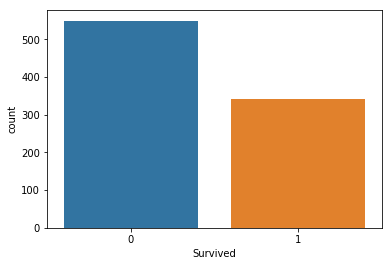

In [5]:
sns.countplot(df_train['Survived'])

### 女人生存率是男人的好幾倍

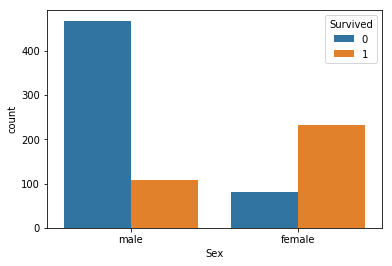

In [6]:
sns.countplot(df_train['Sex'], hue=df_train['Survived'])

### 1等艙的生存率最高、再來是2等艙、最後是3等艙

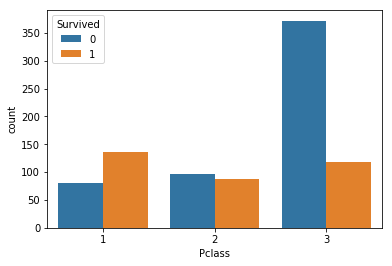

In [7]:
sns.countplot(df_train['Pclass'], hue=df_train['Survived'])

### S港出發的都比較容易死亡

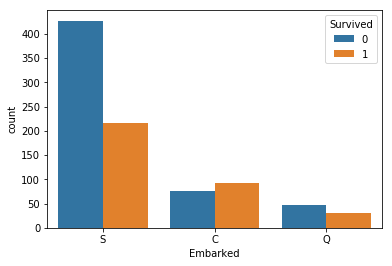

In [8]:
sns.countplot(df_train['Embarked'], hue=df_train['Survived'])

### 年齡小的存活比例高

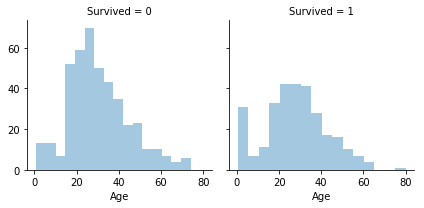

In [9]:
g = sns.FacetGrid(df_train, col='Survived')
g.map(sns.distplot, 'Age', kde=False)

### 沒有跟家人一起上船的，生存率偏低

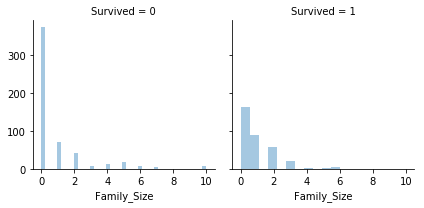

In [10]:
# 把「父母＋小孩」加上「兄弟姊妹＋丈夫妻子」的數量變成一個新的欄位叫做家庭大小
df_train['Family_Size'] = df_train['Parch'] + df_train['SibSp']

g = sns.FacetGrid(df_train, col='Survived')
g.map(sns.distplot, 'Family_Size', kde=False)

## 取出目標欄位

In [112]:
Y_train = df_train['Survived']

df_train = df_train.drop(['Survived'] , axis=1) # 移除欄位

## 取出非特徵欄位

In [113]:
ids = df_test['PassengerId']

df_train = df_train.drop(['PassengerId'] , axis=1) # 移除欄位
df_test = df_test.drop(['PassengerId'] , axis=1) # 移除欄位

## 合併df_train、df_test

In [114]:
df = pd.concat([df_train,df_test])
df.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## 填補缺失值
## 編碼
## 歸一化

In [115]:
LEncoder = LabelEncoder()
MMEncoder = MinMaxScaler()
for c in df.columns:
    df[c] = df[c].fillna(-1)
    if df[c].dtype == 'object':
        print(c)
        df[c] = LEncoder.fit_transform(list(df[c].values))
    df[c] = MMEncoder.fit_transform(df[c].values.reshape(-1, 1))
df.head()

Name
Sex
Ticket
Cabin
Embarked


,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,155,1,22.0,1,0,720,7.2500,0,3
1,1,286,0,38.0,1,0,816,71.2833,107,1
2,3,523,0,26.0,0,0,914,7.9250,0,3
3,1,422,0,35.0,1,0,65,53.1000,71,3
4,3,22,1,35.0,0,0,649,8.0500,0,3


## 取得X_train、y_train

In [116]:
train_num = Y_train.shape[0]
X_train = df[:train_num]
X_test = df[train_num:]

## 訓練模型

In [117]:
model = GradientBoostingClassifier()
model.fit(X_train, Y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

## 特徵重要性

In [118]:
importance = pd.Series(data=model.feature_importances_, index=X_train.columns)
importance = importance.sort_values(ascending=False)
print(importance)

Sex         0.443982
Pclass      0.111763
Ticket      0.096048
Fare        0.088123
Name        0.083939
Age         0.073864
Cabin       0.070785
Embarked    0.012220
Parch       0.011557
SibSp       0.007719
dtype: float64


## 預測X_test

In [119]:
# pred = model.predict_proba(X_test)
pred = model.predict(X_test)
sub = pd.DataFrame({'PassengerId': ids, 'Survived': pred})
sub.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


## 儲存預測數據

In [120]:
sub.to_csv('titanic_baseline.csv', index=False) 

## 使用神經網路作為model

In [20]:
import os
import pandas as pd
from pandas import DataFrame
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout  
from keras.optimizers import Adam
from keras.layers import BatchNormalization
from keras.utils import np_utils
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
np.random.seed(1)

Using TensorFlow backend.


In [102]:
model = Sequential()  
model.add(Dense(units=40, input_dim=11, activation='relu'))
model.add(Dense(units=40, activation='relu'))
model.add(Dense(units=40, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))  
# model.summary()  

model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])  

In [103]:
train_history = model.fit(x=X_train, y=Y_train, validation_split=0.1, epochs=50, batch_size=30)  

Train on 801 samples, validate on 90 samples
Epoch 1/50
801/801 [==============================] - 1s 783us/step - loss: 0.6385 - acc: 0.6005 - val_loss: 0.5822 - val_acc: 0.6222
Epoch 2/50
801/801 [==============================] - 0s 45us/step - loss: 0.5690 - acc: 0.6729 - val_loss: 0.5234 - val_acc: 0.7778
Epoch 3/50
801/801 [==============================] - 0s 36us/step - loss: 0.5168 - acc: 0.7690 - val_loss: 0.4952 - val_acc: 0.7778
Epoch 4/50
801/801 [==============================] - 0s 36us/step - loss: 0.4901 - acc: 0.7840 - val_loss: 0.4826 - val_acc: 0.7778
Epoch 5/50
801/801 [==============================] - 0s 34us/step - loss: 0.4790 - acc: 0.7790 - val_loss: 0.4757 - val_acc: 0.7889
Epoch 6/50
801/801 [==============================] - 0s 33us/step - loss: 0.4751 - acc: 0.7778 - val_loss: 0.4657 - val_acc: 0.7889
Epoch 7/50
801/801 [==============================] - 0s 32us/step - loss: 0.4629 - acc: 0.7965 - val_loss: 0.4514 - val_acc: 0.8000
Epoch 8/50
801/801 [===

In [107]:
pred = model.predict(X_test)
print(pred[:5])
pred = pred.reshape(-1)
print(pred[:5])
print(pred.shape)
sub = pd.DataFrame({'PassengerId': ids, 'Survived': pred})
sub.head()

[[0.06744814]
 [0.26904938]
 [0.05292958]
 [0.05960044]
 [0.54483914]]
[0.06744814 0.26904938 0.05292958 0.05960044 0.54483914]
(418,)


,PassengerId,Survived
0,892,0.067448
1,893,0.269049
2,894,0.052930
3,895,0.059600
4,896,0.544839


In [108]:
sub['Survived'] = sub['Survived'].map(lambda x: 1 if float(x)>=0.5 else 0)
sub.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [109]:
sub.to_csv('titanic_baseline_nn.csv', index=False) 